In [1]:
import os, sys
import json
import tweepy
import tarfile
import shutil

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import time
from time import mktime
import datetime

In [2]:
# NLR

import MeCab
mecab = MeCab.Tagger (r"-Ochasen -d C:\Users\myaun\Downloads\ipadic-neologd")

import re
import unicodedata
import neologdn

from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

from gensim import corpora, models

C:\Users\myaun\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# normarize

def clean_text(text):
    #replaced_text = '\n'.join(s.strip() for s in text.splitlines()[2:] if s != '')  # skip header by [2:]
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    #replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text=re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", replaced_text)
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    for rmword in ['w', 'W', 'ｗ', 'Ｗ', '笑']:
        replaced_text = replaced_text.replace(rmword, '')
    return replaced_text

def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text

def normalize_text( text ):
    text = clean_text(text)
    text = unicodedata.normalize('NFC', text)
    text = neologdn.normalize(text)
    # text = normalize_number(text)    
    return text

def remove_stopwords( tokens ):
    filtered = []
    for w in tokens:
        if w not in stopWords:
            filtered.append(w)
    return filtered

# tokenize

def get_tokens( text ):
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        token.append( result.surface )
        result = result.next
    tokens = remove_stopwords( tokens )
    return tokens

def get_nouns( text ):
    nouns = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        if pos == '名詞': nouns.append( result.surface )
        result = result.next
    tokens = remove_stopwords( nouns )
    return tokens

def get_entity( text ):
    entity = []
    result = mecab.parseToNode( text )
    while result:
        line = result.feature.split(',')
        pos, tag = line[0], line[1]
        if tag == '固有名詞': entity.append( result.surface )
        result = result.next
    tokens = remove_stopwords( entity )
    return tokens

def get_keywords_tfidf( yt_keys, idx2vid, name, BoW, tfidf_th_percentile ):
    dictionary = corpora.Dictionary( BoW )
    corpus = [dictionary.doc2bow(text) for text in BoW]
    tfidf = models.TfidfModel(corpus,normalize=True)

    vals = []
    for i in range( tfidf.num_docs ):
        for x in tfidf[corpus[i]]: vals.append(x[1])
    if len( vals ) == 0: th = 1.0
    else: th = np.percentile( np.array( vals ), tfidf_th_percentile)

    for idx, vid in idx2vid.items():
        title_keys = []
        for x in sorted( tfidf[corpus[idx]], key=lambda x:x[1], reverse=True ):
            if x[1] < th: continue
            title_keys.append( tuple([dictionary[x[0]], x[1]]) )
        yt_keys[vid][name] = title_keys
    return yt_keys


In [ ]:
# query = "#欅って書けない"

In [4]:
query = "#欅って書けない"
savepath =  "../data/tweet"
query_dir = "%s/%s" % (savepath, query)
if not os.path.exists( query_dir ):
    os.mkdir(query_dir)
    
rows = []

target_dir = '%s/1'%(query_dir)
files = os.listdir(target_dir)
for idx, file in enumerate(files):
    f = open('%s/%s' % (target_dir, file), 'r')
    tweet = json.load(f)
    f.close()
    
    struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
    dt = datetime.datetime.fromtimestamp(mktime(struct))
    dt_diff = dt + datetime.timedelta(hours=9)

    rows.append( [dt_diff, tweet['text']] )

In [5]:
df = pd.DataFrame( rows, columns=['created_at', 'text'] )
print( df.shape )
df.head()

(6935, 2)


,created_at,text
0,2019-01-21 00:17:30,志田と今泉、降臨パターンワンチャン？
1,2019-01-21 00:17:55,けやかけDAY 🌳\n#欅って書けない
2,2019-01-21 00:27:51,けど、うちも負けてないはずだ。\n\n#欅って書けない
3,2019-01-21 00:28:18,うし。\n欅書けとひら推し見ますか！！\n\n#欅坂46\n#けやき坂46\n#欅って書けな...
4,2019-01-21 00:28:33,さぁーーーーけやかけ待機！！推しが長く映る日です。（基本箱推しだから誰がフィーチャーされても...


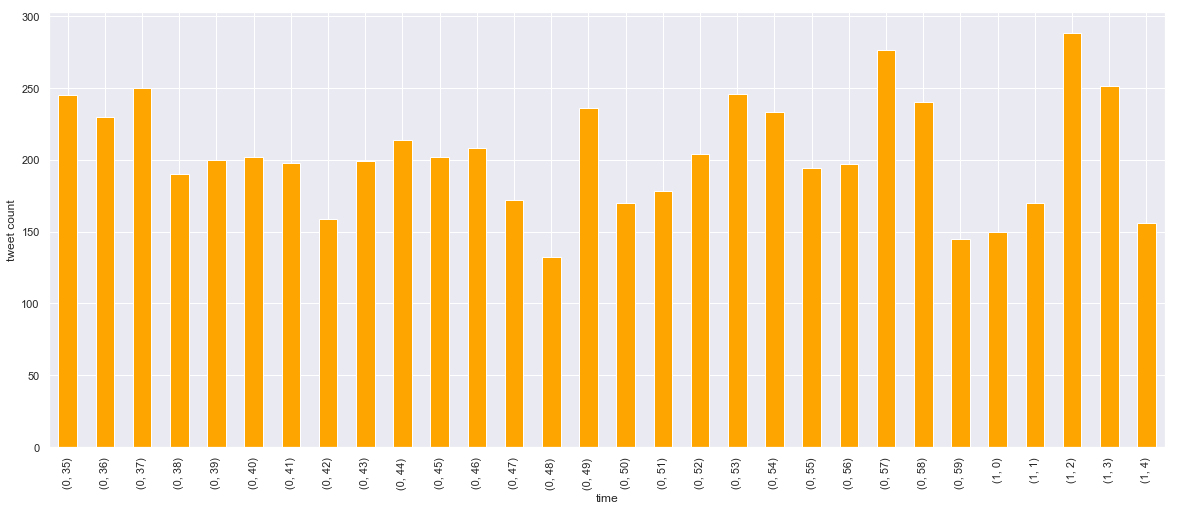

In [7]:
onair_time = ['2019-01-21 00:35', '2019-01-21 01:05']
df_onair = df.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))

df_onair['created_at'].groupby([df_onair["created_at"].dt.hour, df_onair["created_at"].dt.minute]).count().plot(
    x='time', kind="bar", color="orange", figsize=(20, 8))
plt.xlabel("time", fontdict={'size': 12})
plt.ylabel("tweet count", fontdict={'size': 12})
plt.show()

In [8]:
grouped = df_onair.groupby([df["created_at"].dt.hour, df["created_at"].dt.minute])

for key in grouped.groups.keys():
    texts = grouped.get_group(key)['text'].values.tolist()
    BoE = [ get_entity( normalize_text( text ) ) for text in texts ]
    dictionary = corpora.Dictionary( BoE )
    # top10 = [ (dictionary[i], j) for i, j in sorted( dictionary.dfs.items(), key=lambda x:x[1], reverse=True)[1:11] ]
    top10 = [ dictionary[i] for i, j in sorted( dictionary.dfs.items(), key=lambda x:x[1], reverse=True)[:10] ]
    print( '%2d時%2d分  tweet_num:%d　-> keywords:' % (key[0], key[1], len(texts)), top10 )

 0時35分  tweet_num:245　-> keywords: ['けやかけ', 'ツッコミ', '欅坂46', '土生', '#tvtokyo', '理佐', '98年', 'リアタイ', 'もん', 'フォーメーション']
 0時36分  tweet_num:230　-> keywords: ['けやかけ', '新成人', '欅坂46', '土生', 'ツッコミ', '理佐', '6人', 'りさ', '20歳', '98年']
 0時37分  tweet_num:250　-> keywords: ['理佐', 'けやかけ', 'みい', '欅坂46', '土生', '20歳', 'りさ', '小池', '愛佳', '4人']
 0時38分  tweet_num:190　-> keywords: ['けやかけ', '織田', '理佐', 'みい', '欅坂46', 'みぃちゃん', '自撮り', '大惨事', '樂', 'りさ']
 0時39分  tweet_num:200　-> keywords: ['お酒', '理佐', 'みい', 'けやかけ', 'りさ', '20歳', '欅坂46', 'ほろよい', 'チューハイ', '織田']
 0時40分  tweet_num:202　-> keywords: ['みい', '欅坂46', '理佐', 'お酒', 'けやかけ', '4人', '織田', '守屋', '#tvtokyo', '織田奈那']
 0時41分  tweet_num:198　-> keywords: ['欅坂46', 'けやかけ', '理佐', '織田', 'みい', 'みぃちゃん', '好きな人', 'りさ', '世界三大珍味', 'おだ']
 0時42分  tweet_num:159　-> keywords: ['けやかけ', '彦摩呂', '欅坂46', '世界三大珍味', 'りさ', '織田', '新成人', '#tvtokyo', '1番', '三大']
 0時43分  tweet_num:199　-> keywords: ['イカスミ', '欅坂46', '織田', 'けやかけ', '織田奈那', '三大', '4人', '理佐', 'おだ', 'なな']
 0時44分  tweet_num:214　-> keywords:

In [11]:
# query = "#ひらがな推し"

In [9]:
query = "#ひらがな推し"
savepath =  "../data/tweet"
query_dir = "%s/%s" % (savepath, query)
if not os.path.exists( query_dir ):
    os.mkdir(query_dir)
    
rows = []

target_dir = '%s/1'%(query_dir)
files = os.listdir(target_dir)
for idx, file in enumerate(files):
    f = open('%s/%s' % (target_dir, file), 'r')
    tweet = json.load(f)
    f.close()
    
    struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
    dt = datetime.datetime.fromtimestamp(mktime(struct))
    dt_diff = dt + datetime.timedelta(hours=9)

    rows.append( [dt_diff, tweet['text']] )

In [10]:
df = pd.DataFrame( rows, columns=['created_at', 'text'] )
print( df.shape )
df.head()

(8164, 2)


,created_at,text
0,2019-01-21 00:21:07,本日リアルタイム(25:05〜)でひらがな推しの画像、動画等をアップする【ひらがな推しハイラ...
1,2019-01-21 00:21:09,ひなのなの♥️\n\n#けやき坂46 #ひらがな推し\n#上村ひなの https://t.c...
2,2019-01-21 00:23:17,浮島綱引きバトル\nみーぱんvsきくちゃん\n\n#けやき坂46 #ひらがな推し #佐々木美...
3,2019-01-21 00:28:18,うし。\n欅書けとひら推し見ますか！！\n\n#欅坂46\n#けやき坂46\n#欅って書けな...
4,2019-01-21 00:29:08,乃木中見てたら寝れなくなった😓\nこの際だからひらがな推しまでみちゃうか⁉️\n#乃木坂工事...


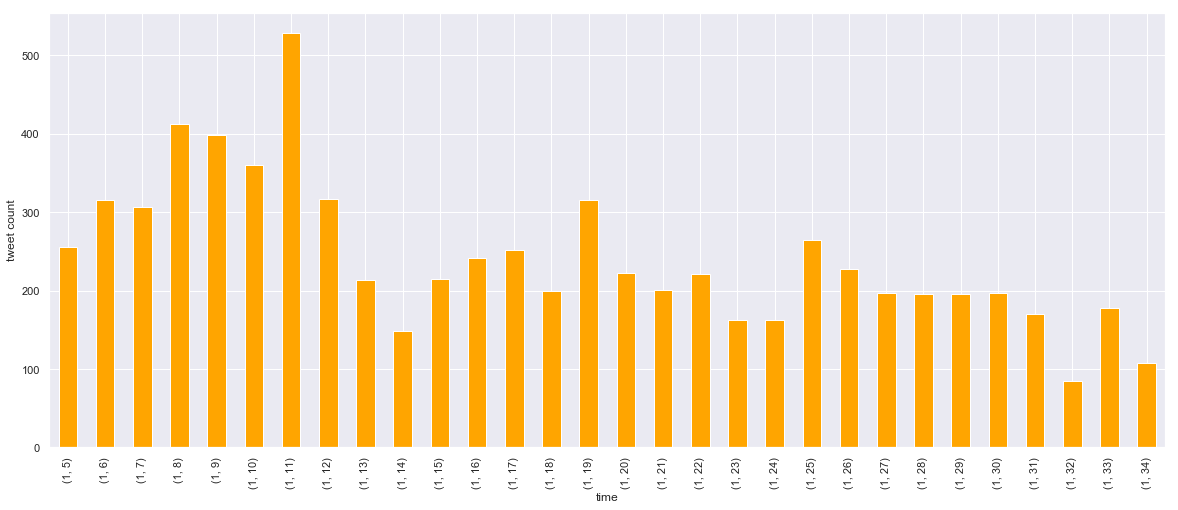

In [11]:
onair_time = ['2019-01-21 01:05', '2019-01-21 01:35']
df_onair = df.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))

df_onair['created_at'].groupby([df_onair["created_at"].dt.hour, df_onair["created_at"].dt.minute]).count().plot(
    x='time', kind="bar", color="orange", figsize=(20, 8))
plt.xlabel("time", fontdict={'size': 12})
plt.ylabel("tweet count", fontdict={'size': 12})
plt.show()

In [12]:
grouped = df_onair.groupby([df["created_at"].dt.hour, df["created_at"].dt.minute])

for key in grouped.groups.keys():
    texts = grouped.get_group(key)['text'].values.tolist()
    BoE = [ get_entity( normalize_text( text ) ) for text in texts ]
    dictionary = corpora.Dictionary( BoE )
    # top10 = [ (dictionary[i], j) for i, j in sorted( dictionary.dfs.items(), key=lambda x:x[1], reverse=True)[1:11] ]
    top10 = [ dictionary[i] for i, j in sorted( dictionary.dfs.items(), key=lambda x:x[1], reverse=True)[1:11] ]
    print( '%2d時%2d分  tweet_num:%d　-> keywords:' % (key[0], key[1], len(texts)), top10 )

 1時 5分  tweet_num:255　-> keywords: ['ちゅどーん', 'ハムカツ', 'ちゅ', 'けやき坂46', 'ひらがな', '井口', 'まな', '乃木坂工事中', '乃木中', '30分']
 1時 6分  tweet_num:315　-> keywords: ['柿崎', 'ハムカツ', 'ぶりっ子', 'けやき坂46', '丹生', '菜緒', '愛萌', 'きょん', '井口', '#tvtokyo']
 1時 7分  tweet_num:307　-> keywords: ['丹生', 'このちゃん', '若林', '陽菜', 'ω', '松田', '#tvtokyo', 'けやき坂46', 'ぶりっ子', '柿崎']
 1時 8分  tweet_num:412　-> keywords: ['丹生', '柿崎', '若林', 'ウイニングラン', '松田', '小坂', 'ぶりっ子', 'このか', 'けやき坂46', '実']
 1時 9分  tweet_num:398　-> keywords: ['若林', '丹生', 'きょん', '柿崎', '小坂', 'けやき坂46', '愛萌', 'このちゃん', '小坂菜緒', '菜緒']
 1時10分  tweet_num:360　-> keywords: ['きょん', 'まな', '丹生', '若林', '愛萌', '久美', 'けやき坂46', '齊藤京子', '宮田', '京子']
 1時11分  tweet_num:528　-> keywords: ['まな', '愛萌', '宮田', 'きょん', '宮田愛', '萌', 'けやき坂46', '久美', '齊藤京子', '丹生']
 1時12分  tweet_num:317　-> keywords: ['まな', '愛萌', '宮田', 'きょん', '宮田愛', '萌', '前前前世', 'けやき坂46', '若林', '丹生']
 1時13分  tweet_num:213　-> keywords: ['愛萌', 'まな', '寸止め', '若林', '宮田', '丹生', 'きょん', 'けやき坂46', '萌', '宮田愛']
 1時14分  tweet_num:149　-> keywords: ['オードリー

In [15]:
query = "#乃木坂工事中"
savepath =  "../data/tweet"
query_dir = "%s/%s" % (savepath, query)
if not os.path.exists( query_dir ):
    os.mkdir(query_dir)

In [16]:
files = os.listdir(query_dir)
files

['0.tar.gz', '1.tar.gz', '2']

In [17]:
rows = []

for idx, file in enumerate(files):
    print( idx, file )
    if os.path.isfile( "%s/%s" % (query_dir, file) ): # file
        taffile_path = "%s/%s" % (query_dir, file)
        tf = tarfile.open( taffile_path , 'r')
        for fname_in_tar in tf.getnames():
            f = tf.extractfile( fname_in_tar )
            tweet = json.loads( f.read().decode() )
            struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
            dt = datetime.datetime.fromtimestamp(mktime(struct))
            dt_diff = dt + datetime.timedelta(hours=9)

            rows.append( [dt_diff, tweet['text']] )  
    else: # dir
        target_dir = "%s/%s" % (query_dir, file)
        files = os.listdir(target_dir)
        for idx, file in enumerate(files):
            f = open('%s/%s' % (target_dir, file), 'r')
            tweet = json.load(f)
            f.close()

            struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
            dt = datetime.datetime.fromtimestamp(mktime(struct))
            dt_diff = dt + datetime.timedelta(hours=9)

            rows.append( [dt_diff, tweet['text']] )

0 0.tar.gz
1 1.tar.gz
2 2


In [18]:
df = pd.DataFrame( rows, columns=['created_at', 'text'] )
print( df.shape )
df.head()

(13871, 2)


,created_at,text
0,2019-01-21 00:18:44,は、めっちゃ可愛い #乃木坂工事中
1,2019-01-21 00:18:44,やくぼちゃん！！！\n#乃木坂工事中
2,2019-01-21 00:18:44,ウチの大学にもこんなリクルートスーツ似合う女子いねえかな…\n\n #乃木坂工事中
3,2019-01-21 00:18:44,#乃木坂工事中 えんどうさくらちゃんが大トリ予想
4,2019-01-21 00:18:44,生ドルコンビ\n#乃木坂工事中


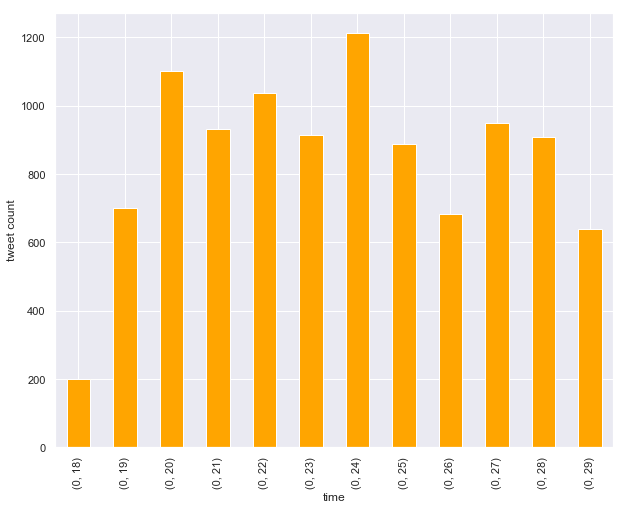

In [21]:
onair_time = ['2019-01-21 00:00', '2019-01-21 00:30']
df_onair = df.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))

df_onair['created_at'].groupby([df_onair["created_at"].dt.hour, df_onair["created_at"].dt.minute]).count().plot(
    x='time', kind="bar", color="orange", figsize=(10, 8))
plt.xlabel("time", fontdict={'size': 12})
plt.ylabel("tweet count", fontdict={'size': 12})
plt.show()

In [22]:
grouped = df_onair.groupby([df["created_at"].dt.hour, df["created_at"].dt.minute])

for key in grouped.groups.keys():
    texts = grouped.get_group(key)['text'].values.tolist()
    BoE = [ get_entity( normalize_text( text ) ) for text in texts ]
    dictionary = corpora.Dictionary( BoE )
    # top10 = [ (dictionary[i], j) for i, j in sorted( dictionary.dfs.items(), key=lambda x:x[1], reverse=True)[1:11] ]
    top10 = [ dictionary[i] for i, j in sorted( dictionary.dfs.items(), key=lambda x:x[1], reverse=True)[1:11] ]
    print( '%2d時%2d分  tweet_num:%d　-> keywords:' % (key[0], key[1], len(texts)), top10 )

 0時18分  tweet_num:199　-> keywords: ['矢久保', '久保', '美緒', '松村', '柴田', '与田', '乃木中', 'コール', 'かずみ', 'パクチー']
 0時19分  tweet_num:701　-> keywords: ['矢久保', '美緒', '久保', 'juju', '松村', 'じゅじゅ', 'ちゅん', '乃木中', '4期', '乃木坂46']
 0時20分  tweet_num:1103　-> keywords: ['矢久保', '設楽', 'まちゅ', 'ちゅん', '松村', '美緒', 'そうかもしれない', 'さゆりん', '久保', '乃木中']
 0時21分  tweet_num:933　-> keywords: ['矢久保', '藤森', 'コール', '美緒', '乃木中', 'ガチ', '設楽', '中田', '久保', '乃木坂46']
 0時22分  tweet_num:1036　-> keywords: ['焼きそばパン', '矢久保', '美緒', '乃木坂46', 'フライドチキン', 'コール', '乃木中', '久保', '4期生', 'たくあん']
 0時23分  tweet_num:915　-> keywords: ['矢久保', '焼きそばパン', '美緒', 'コール', '中田', '久保', '乃木中', '乃木坂46', '4期生', 'まちゅ']
 0時24分  tweet_num:1212　-> keywords: ['矢久保', '美緒', 'まちゅ', '中田', '松村', 'コール', '焼きそばパン', '乃木坂46', '乃木中', '4期']
 0時25分  tweet_num:889　-> keywords: ['矢久保', '美緒', '4期生', '4期', '乃木中', '中田', '松村', '3週', '乃木坂', '久保']
 0時26分  tweet_num:684　-> keywords: ['矢久保', '焼きそばパン', '設楽', 'バナナマン', 'エビフライ', '美緒', '乃木中', '乃木坂46', 'コール', '4期']
 0時27分  tweet_num:950　-> keywords: ['飛